In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import scipy.linalg as linalg
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as skl
import math
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from typing import List, Any 
from collections import Counter

In [40]:
video_games = pd.read_csv("data/Jeux_Videos.csv", sep=",")

In [41]:
class Variable:
    genres = "genres" # qualitative nominal 
    overall_review = "overall_review" # qualitative ordinal
    overall_review_percentage = "overall_review_%" # quantitative continue 
    awards = "awards" # quantitative discrete

    original_price = "original_price"
    discount_percentage = "discount_percentage"
    
    overall_review_order = [
        "Overwhelmingly Negative", "Very Negative", "Negative", "Mostly Negative",
        "Mixed", "Mostly Positive", "Positive", "Very Positive", "Overwhelmingly Positive"
    ]


In [42]:
def statistical_analysis_quantitative(series: pd.Series, cutted: bool = False, include_graph: bool = False) -> None:  
    print(f"\n Taille de la population : {series.count()} observations")  
    print(f" Minimum : {series.min()}")  
    print(f" Maximum : {series.max()}")  

    if cutted:
        # Calcul du pas
        num_bins = math.floor(math.sqrt(series.count()))
        
        # Découpage en classes
        cutted_series = pd.cut(series, bins=num_bins, precision=2)

        # Effectif par classe
        bin_counts = series.groupby(cutted_series).count()
        bin_cumulative_counts = bin_counts.cumsum()
        
        # Fréquences
        bin_frequencies = bin_counts / bin_counts.sum()
        bin_cumulative_frequencies = bin_frequencies.cumsum()

        # Médianes et modes
        medians = series.groupby(cutted_series).median().reindex(bin_counts.index)
        modes = series.groupby(cutted_series).apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reindex(bin_counts.index)

        # Création du tableau avec alignement des longueurs
        df_bins = pd.DataFrame({
            "Classe": bin_counts.index.astype(str),
            "Effectif": bin_counts.values,
            "Effectif cumulé": bin_cumulative_counts.values,
            "Fréquence": bin_frequencies.values,
            "Fréquence cumulée": bin_cumulative_frequencies.values,
            "Médiane": medians.values,
            "Mode": modes.values
        })

        print("\n Analyse par classes :")
        print(df_bins.to_string(index=False, formatters={
            "Fréquence": "{:.2%}".format, 
            "Fréquence cumulée": "{:.2%}".format
        }))

    else:
        # Analyse par valeur unique
        counts = series.value_counts().sort_index()
        cumulative_counts = counts.cumsum()
        frequencies = counts / series.count()
        cumulative_frequencies = frequencies.cumsum()

        df_stats = pd.DataFrame({
            "Valeur": counts.index,
            "Effectif": counts.values,
            "Effectif cumulé": cumulative_counts.values,
            "Fréquence": frequencies.values,
            "Fréquence cumulée": cumulative_frequencies.values
        })

        print("\n Analyse des valeurs uniques :")
        print(df_stats.to_string(index=False, formatters={
            "Fréquence": "{:.2%}".format, 
            "Fréquence cumulée": "{:.2%}".format
        }))

        print("\n Statistiques principales :")
        print(f"- Moyenne : {series.mean():.3f}")
        print(f"- Médiane : {series.median():.3f}")
        print(f"- Mode(s) : {', '.join(map(str, series.mode().tolist()))}")
        print(f"- 25% (Q1) : {series.quantile(0.25):.3f}")
        print(f"- 50% (Q2 - Médiane) : {series.quantile(0.5):.3f}")
        print(f"- 75% (Q3) : {series.quantile(0.75):.3f}")
        print(f"- Étendue : {series.max() - series.min():.3f}")
        print(f"- Écart interquartile (Q3 - Q1) : {series.quantile(0.75) - series.quantile(0.25):.3f}")
        print(f"- Écart-type : {series.std():.3f}")
        print(f"- Variance : {series.var():.3f}")

    # Affichage des graphiques
    if include_graph:
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))

        # Histogramme
        ax[0].hist(series.dropna(), bins=math.floor(math.sqrt(series.count())), color="skyblue", alpha=0.7, edgecolor="black")
        ax[0].set_xlabel("Valeurs")
        ax[0].set_ylabel("Effectif")
        ax[0].set_title("Histogramme des valeurs")

        # CDF (Courbe de répartition empirique)
        sorted_data = np.sort(series.dropna())
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax[1].plot(sorted_data, cdf, marker="o", linestyle="-", color="orange")
        ax[1].set_xlabel("Valeurs")
        ax[1].set_ylabel("Probabilité cumulée")
        ax[1].set_title("Fonction de répartition empirique (CDF)")

        # Boxplot
        ax[2].boxplot(series.dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
        ax[2].set_title("Boxplot de la variable")

        plt.tight_layout()
        plt.show()


In [43]:
def statistical_analysis_qualitative_ordinal(series: pd.Series, include_graph: bool = False, custom_order: List[Any] = []) -> None:
    print(f"\n Taille de la population : {series.count()} observations")  # Nombre total d'observations
    
    # Vérifier si un ordre personnalisé est fourni
    if custom_order:
        value_counts = series.value_counts()
        counts = value_counts.reindex(custom_order).dropna()
    else:
        counts = series.value_counts().sort_index()  # Tri automatique si pas d'ordre personnalisé

    # Calcul des effectifs cumulés
    cumulative_counts = counts.cumsum()

    # Calcul des fréquences
    frequencies = counts / series.count()
    cumulative_frequencies = frequencies.cumsum()

    # Détermination du mode (valeur la plus fréquente)
    max_effectif = counts.max()
    mode_values = counts[counts == max_effectif].index.tolist()

    # Détermination de la médiane (valeur centrale)
    cumulative_counts_half = cumulative_counts[cumulative_counts >= series.count() / 2]
    mediane = cumulative_counts_half.index[0] if not cumulative_counts_half.empty else "Indéterminée"

    # Création du DataFrame pour affichage
    df_stats = pd.DataFrame({
        "Valeur": counts.index,
        "Effectif": counts.values,
        "Effectif cumulé": cumulative_counts.values,
        "Fréquence": frequencies.values,
        "Fréquence cumulée": cumulative_frequencies.values
    })

    # Affichage du tableau formaté
    print("\n Analyse de la variable ordinale :")
    print(df_stats.to_string(index=False, formatters={
        "Fréquence": "{:.2%}".format, 
        "Fréquence cumulée": "{:.2%}".format
    }))

    # Affichage des statistiques complémentaires
    print("\n Statistiques complémentaires :")
    print(f"- Mode(s) : {', '.join(map(str, mode_values))}")
    print(f"- Médiane : {mediane}")

    # Affichage des graphiques si demandé
    if include_graph:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Diagramme en barres (répartition des valeurs)
        ax[0].bar(df_stats["Valeur"], df_stats["Effectif"], color="skyblue", alpha=0.7)
        ax[0].set_xlabel("Valeurs")
        ax[0].set_ylabel("Effectif")
        ax[0].set_title("Répartition des valeurs ordinales")
        ax[0].tick_params(axis="x", rotation=45)

        # Courbe des effectifs cumulés
        ax[1].plot(df_stats["Valeur"], df_stats["Effectif cumulé"], marker="o", linestyle="-", color="orange")
        ax[1].set_xlabel("Valeurs")
        ax[1].set_ylabel("Effectif cumulé")
        ax[1].set_title("Effectifs cumulés")

        # Boxplot
        if custom_order:
            mapping = {val: i for i, val in enumerate(custom_order)}  # Associer chaque valeur à un nombre
            series_numeric = series.map(mapping).dropna()  # Appliquer la conversion
            ax[2].boxplot(series_numeric, vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
            ax[2].set_title("Boxplot (Valeurs ordinales converties)")

        plt.tight_layout()
        plt.show()



In [44]:
def statistical_analysis_qualitative_nominal(series: pd.Series, include_graph: bool = False) -> None:
    # Initialiser un compteur pour stocker les fréquences des genres
    compteur_genres = Counter()

    # Parcourir les lignes et compter les occurrences des genres
    for genres in series.dropna():
        liste_genres = [genre.strip() for genre in genres.split(",")]
        compteur_genres.update(liste_genres)

    # Trier les genres par fréquence décroissante
    genres_tries = dict(sorted(compteur_genres.items(), key=lambda x: x[1], reverse=True))

    # Calcul des effectifs, effectifs cumulés, fréquences et fréquences cumulées
    total = sum(genres_tries.values())
    effectifs_cumules = []
    frequences = []
    frequences_cumulees = []

    cumul = 0
    for genre, effectif in genres_tries.items():
        cumul += effectif
        effectifs_cumules.append(cumul)
        frequence = effectif / total
        frequences.append(frequence)
        frequences_cumulees.append(cumul / total)

    # Détermination du mode (les valeurs les plus fréquentes)
    max_effectif = max(genres_tries.values())
    mode_genres = [genre for genre, effectif in genres_tries.items() if effectif == max_effectif]

    # Création du DataFrame pour affichage
    df_stats = pd.DataFrame({
        "Genre": list(genres_tries.keys()),
        "Effectif": list(genres_tries.values()),
        "Effectif cumulé": effectifs_cumules,
        "Fréquence": frequences,
        "Fréquence cumulée": frequences_cumulees
    })

    # Affichage du tableau des statistiques
    print("\nAnalyse des genres de jeux vidéo :")
    print(df_stats.to_string(index=False, formatters={"Fréquence": "{:.2%}".format, "Fréquence cumulée": "{:.2%}".format}))
    
    # Affichage des statistiques supplémentaires
    print("\nMode(s) des genres les plus fréquents :", ", ".join(mode_genres))

    # Affichage des graphiques si demandé
    if include_graph:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Histogramme (Bar Chart)
        ax[0].bar(df_stats["Genre"], df_stats["Effectif"], color="skyblue", alpha=0.7)
        ax[0].set_xlabel("Genres")
        ax[0].set_ylabel("Effectif")
        ax[0].set_title("Répartition des genres")
        ax[0].tick_params(axis="x", rotation=45)

        # Diagramme en camembert (Pie Chart)
        ax[1].pie(df_stats["Effectif"], labels=df_stats["Genre"], autopct="%1.1f%%", colors=plt.cm.Paired.colors)
        ax[1].set_title("Répartition des genres (Pie Chart)")

        plt.tight_layout()
        plt.show()


Analyse des genres de jeux vidéo :
                Genre  Effectif  Effectif cumulé Fréquence Fréquence cumulée
                Indie     30033            30033    24.58%            24.58%
               Action     18176            48209    14.87%            39.45%
            Adventure     17857            66066    14.61%            54.06%
               Casual     16321            82387    13.36%            67.42%
           Simulation      9890            92277     8.09%            75.51%
             Strategy      9054           101331     7.41%            82.92%
                  RPG      7891           109222     6.46%            89.38%
         Free to Play      3925           113147     3.21%            92.59%
         Early Access      3879           117026     3.17%            95.76%
               Sports      2228           119254     1.82%            97.58%
               Racing      1708           120962     1.40%            98.98%
Massively Multiplayer      1204         

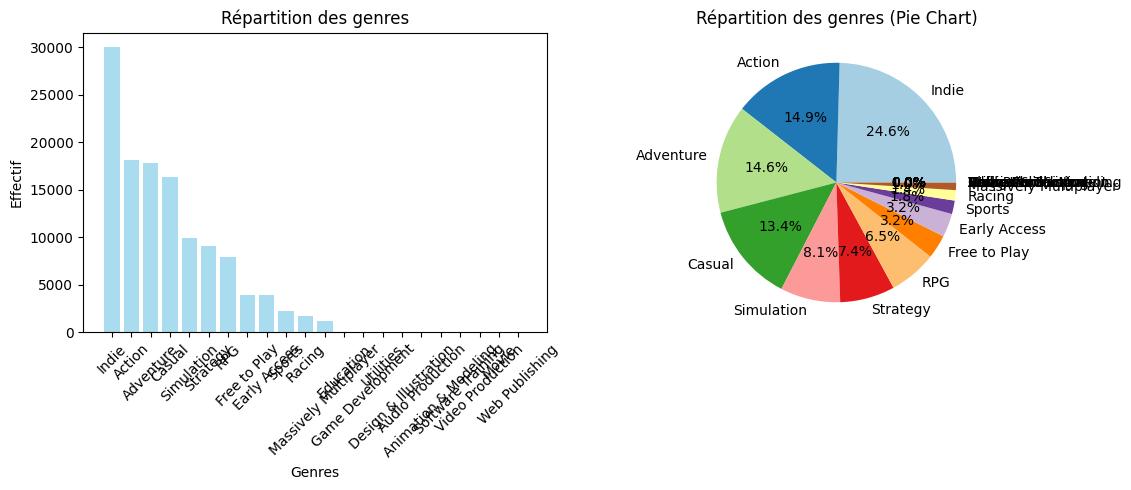

In [45]:
statistical_analysis_qualitative_nominal(video_games[Variable.genres], include_graph=True)


 Taille de la population : 40020 observations
 Minimum : 0.0
 Maximum : 100.0

 Analyse des valeurs uniques :
 Valeur  Effectif  Effectif cumulé Fréquence Fréquence cumulée
    0.0         9                9     0.02%             0.02%
    3.0         2               11     0.00%             0.03%
    4.0         2               13     0.00%             0.03%
    5.0         8               21     0.02%             0.05%
    6.0         5               26     0.01%             0.06%
    7.0        11               37     0.03%             0.09%
    8.0        13               50     0.03%             0.12%
    9.0        18               68     0.04%             0.17%
   10.0        19               87     0.05%             0.22%
   11.0         8               95     0.02%             0.24%
   12.0        13              108     0.03%             0.27%
   13.0        12              120     0.03%             0.30%
   14.0        18              138     0.04%             0.34%
   15.0

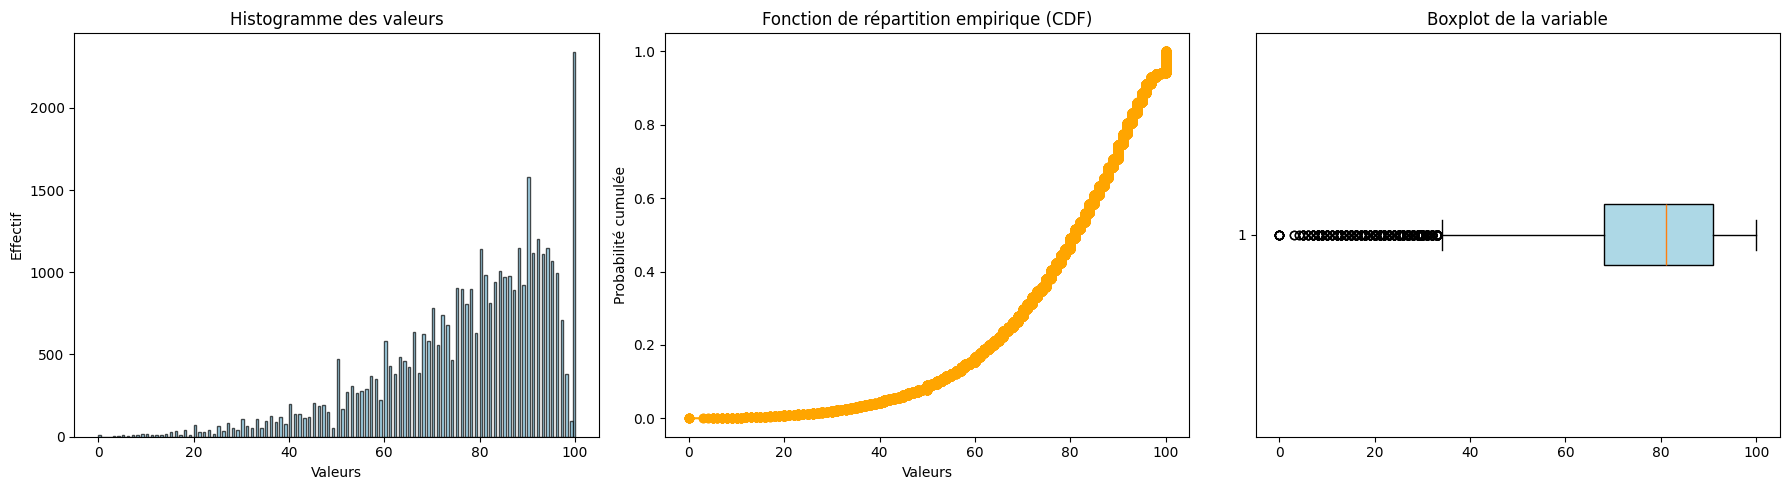

In [46]:
statistical_analysis_quantitative(video_games[Variable.overall_review_percentage], cutted=False, include_graph=True)


 Taille de la population : 40020 observations

 Analyse de la variable ordinale :
                 Valeur  Effectif  Effectif cumulé Fréquence Fréquence cumulée
Overwhelmingly Negative         8                8     0.02%             0.02%
          Very Negative        30               38     0.07%             0.09%
               Negative       227              265     0.57%             0.66%
        Mostly Negative      1361             1626     3.40%             4.06%
                  Mixed      9489            11115    23.71%            27.77%
        Mostly Positive      7359            18474    18.39%            46.16%
               Positive      9312            27786    23.27%            69.43%
          Very Positive     11146            38932    27.85%            97.28%
Overwhelmingly Positive      1088            40020     2.72%           100.00%

 Statistiques complémentaires :
- Mode(s) : Very Positive
- Médiane : Positive


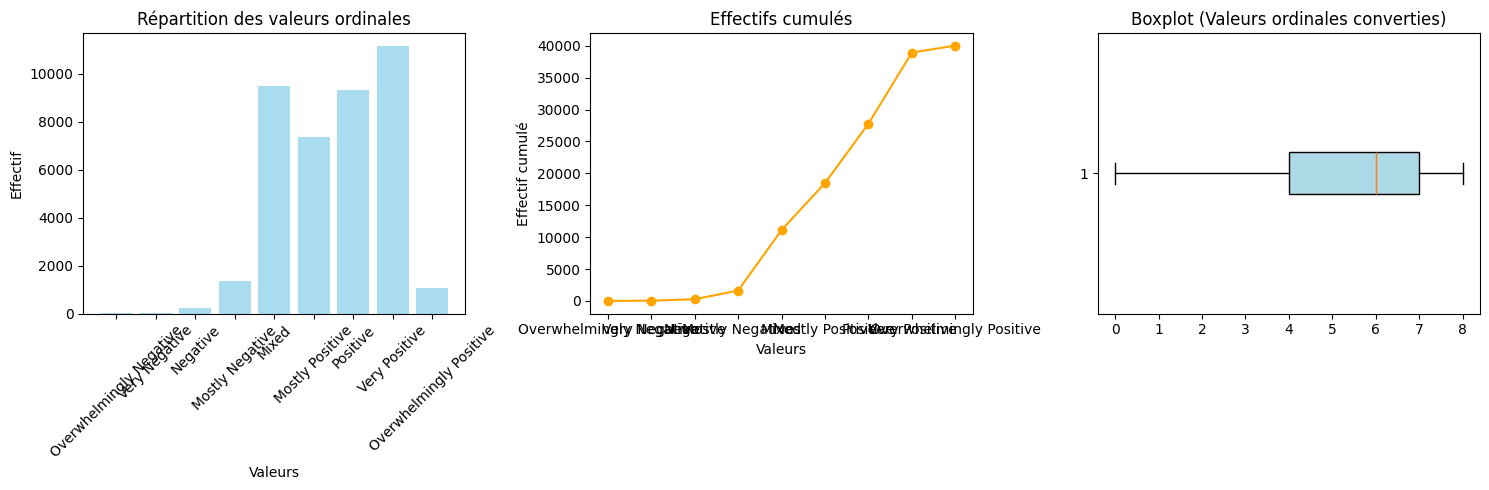

In [47]:
statistical_analysis_qualitative_ordinal(video_games[Variable.overall_review], include_graph=True, custom_order=Variable.overall_review_order)


 Taille de la population : 42497 observations
 Minimum : 0
 Maximum : 41

 Analyse des valeurs uniques :
 Valeur  Effectif  Effectif cumulé Fréquence Fréquence cumulée
      0     37632            37632    88.55%            88.55%
      1      2260            39892     5.32%            93.87%
      2       910            40802     2.14%            96.01%
      3       546            41348     1.28%            97.30%
      4       363            41711     0.85%            98.15%
      5       238            41949     0.56%            98.71%
      6       158            42107     0.37%            99.08%
      7       109            42216     0.26%            99.34%
      8        78            42294     0.18%            99.52%
      9        55            42349     0.13%            99.65%
     10        34            42383     0.08%            99.73%
     11        31            42414     0.07%            99.80%
     12        25            42439     0.06%            99.86%
     13     

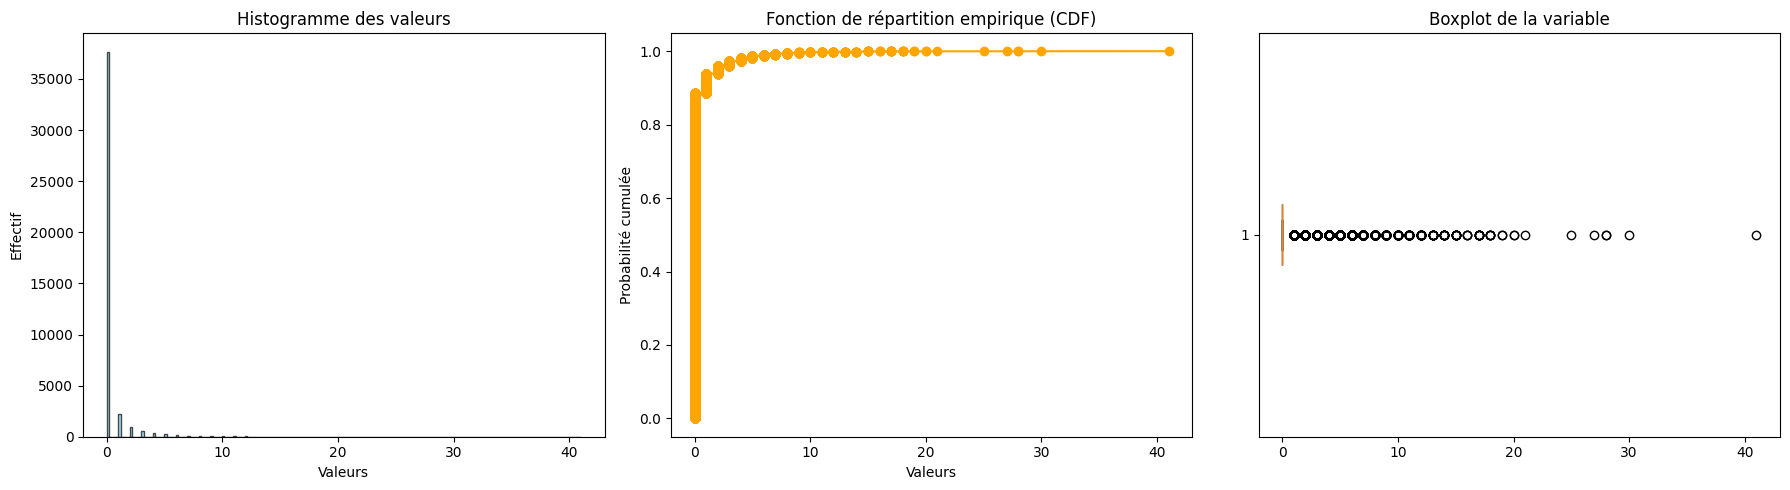

In [48]:
statistical_analysis_quantitative(video_games[Variable.awards], cutted=False, include_graph=True)

<style>
r { color: Red }
o { color: Orange }
g { color: Green }
</style>

## Problématiques bivariées
- 1. Y a-t-il une relation entre le prix initial (original_price) et le pourcentage de réduction (discount_percentage) des jeux ?
(<g>Quantitative</g> vs. <g>Quantitative</g>)
- 2. Le pourcentage de critiques positives (overall_review_%) varie-t-il selon la catégorie du jeu (categories) ?
(<g>Quantitative</g> vs. <r>Qualitative</r>)
- 3. La disponibilité de DLC (dlc_available) influence-t-elle le prix réduit (discounted_price) des jeux ?
(<r>Qualitative</r> vs. <g>Quantitative</g>)
- 4. Le support sur Windows (win_support) affecte-t-il le nombre total de critiques (overall_review_count) ?
(<r>Qualitative</r> vs. <g>Quantitative</g>)
- 5. La classification d'âge (age_rating) d'un jeu est-elle liée à son genre (genres) ?
(<r>Qualitative</r> vs. <r>Qualitative</r>)

## Réponses partielles
- 1. Une analyse préliminaire pourrait consister à calculer le coefficient de corrélation de Pearson entre ces deux variables quantitatives pour évaluer la force et la direction de leur relation (positive, négative ou nulle). On pourrait aussi visualiser cette relation avec un nuage de points (scatter plot).
- 2. On pourrait comparer la moyenne du pourcentage de critiques positives pour chaque catégorie (ex. Solo, Multiplayer) à l’aide d’un test statistique comme une ANOVA ou un test de Kruskal-Wallis si les données ne sont pas normales. Un boxplot pourrait illustrer les différences.
- 3. On pourrait comparer les prix réduits moyens des jeux avec DLC à ceux sans DLC via un test t de Student (si les données sont normales) ou un test de Mann-Whitney sinon. Un diagramme en barres pourrait montrer les différences.
- 4. On pourrait examiner la moyenne du nombre de critiques pour les jeux supportés sur Windows vs. ceux qui ne le sont pas, en utilisant un test t ou Mann-Whitney selon la distribution. Un boxplot pourrait visualiser cette comparaison.
- 5. On pourrait construire une table de contingence entre ces deux variables qualitatives et effectuer un test du Chi² pour tester l’indépendance. Un diagramme en barres empilées pourrait illustrer les proportions.

## Problématiques gardées
- 1. Y a-t-il une relation entre le prix initial (original_price) et le pourcentage de réduction (discount_percentage) des jeux ?
- 2. Le pourcentage de critiques positives (overall_review_%) varie-t-il selon la catégorie du jeu (categories) ?
- 5. La classification d’âge (age_rating) d’un jeu est-elle liée à son genre (genres) ?

In [49]:
# Conversion des prix et pourcentages en valeurs numériques
def clean_price(price_str):
    if pd.isna(price_str) or price_str == 'Free' or price_str == '':
        return 0
    # Extraction du prix numérique (sans devise)
    return float(''.join(char for char in price_str if char.isdigit() or char == '.'))

In [50]:
def clean_discount(discount_str):
    if pd.isna(discount_str) or discount_str == '':
        return 0
    # Extraction du pourcentage (sans le signe %)
    return float(discount_str.strip('%').strip('-'))

In [ ]:
def statistical_analysis_problem_1(original_price_series: pd.Series, discount_percentage_series: pd.Series, include_graph: bool = False) -> None:
        # Chargement des données
    # La première ligne est déjà définie:
    # video_games = pd.read_csv("data/Jeux_Videos.csv", sep=",")

    clean_price_series = original_price_series.apply(clean_price)
    clean_discount_series = discount_percentage_series.apply(clean_discount)
    
    # Création d'un DataFrame temporaire pour l'analyse
    temp_df = pd.DataFrame({
        'original_price_clean': clean_price_series,
        'discount_percentage_clean': clean_discount_series
    })
    
    # Filtrage des jeux payants avec des données valides
    analysis_df = temp_df[temp_df['original_price_clean'] > 0].copy()
    
    print("============ ANALYSE DE LA RELATION PRIX INITIAL - RÉDUCTION ============")
    
    # 1. Statistiques descriptives
    print("\n1. Statistiques descriptives:")
    print(analysis_df.describe())
    
    # Vérification si les données sont suffisantes pour l'analyse
    if len(analysis_df) < 2:
        print("Pas assez de données pour effectuer l'analyse de corrélation.")
        return
    
    # 2. Analyse de corrélation
    correlation = analysis_df['original_price_clean'].corr(analysis_df['discount_percentage_clean'])
    print(f"\n2. Coefficient de corrélation entre prix initial et réduction: {correlation:.4f}")
    
    # Test de signification statistique (p-value)
    corr_test = stats.pearsonr(analysis_df['original_price_clean'], analysis_df['discount_percentage_clean'])
    print(f"   p-value: {corr_test[1]:.4f}")
    
    # Interprétation du coefficient de corrélation
    print("\n   Interprétation du coefficient de corrélation:")
    if abs(correlation) < 0.1:
        strength = "très faible voire inexistante"
    elif abs(correlation) < 0.3:
        strength = "faible"
    elif abs(correlation) < 0.5:
        strength = "modérée"
    elif abs(correlation) < 0.7:
        strength = "forte"
    else:
        strength = "très forte"
        
    direction = "positive" if correlation > 0 else "négative"
    significance = "statistiquement significative" if corr_test[1] < 0.05 else "non statistiquement significative"
    
    print(f"   La corrélation est {strength} et {direction} ({significance}).")
    
    # 3. Modélisation linéaire
    X = analysis_df[['original_price_clean']]
    y = analysis_df['discount_percentage_clean']
    
    model = LinearRegression()
    model.fit(X, y)
    
    print(f"\n3. Modèle linéaire:")
    print(f"   Équation: discount_percentage = {model.coef_[0]:.4f} × original_price + {model.intercept_:.4f}")
    print(f"   R² (coefficient de détermination): {model.score(X, y):.4f}")
    
    # Interprétation du modèle
    print("\n   Interprétation du modèle:")
    if model.coef_[0] > 0:
        print(f"   Pour chaque augmentation de 1 unité du prix initial, le pourcentage de réduction augmente en moyenne de {model.coef_[0]:.4f} points.")
    else:
        print(f"   Pour chaque augmentation de 1 unité du prix initial, le pourcentage de réduction diminue en moyenne de {abs(model.coef_[0]):.4f} points.")
    
    # 4. Analyse par tranches de prix
    analysis_df['price_range'] = pd.cut(analysis_df['original_price_clean'], 
                                        bins=[0, 10, 20, 30, 40, 50, float('inf')],
                                        labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50+'])
    
    price_range_analysis = analysis_df.groupby('price_range')['discount_percentage_clean'].agg(['mean', 'count'])
    print("\n4. Réduction moyenne par tranche de prix:")
    print(price_range_analysis)
    
    # 5. Visualisations (conditionnelles)
    if include_graph:
        # Nuage de points avec ligne de tendance
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='original_price_clean', y='discount_percentage_clean', data=analysis_df, alpha=0.6)
        sns.regplot(x='original_price_clean', y='discount_percentage_clean', data=analysis_df, 
                    scatter=False, color='red', line_kws={"linestyle": "--"})
        plt.title('Relation entre prix initial et pourcentage de réduction')
        plt.xlabel('Prix initial')
        plt.ylabel('Pourcentage de réduction')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Graphique à barres par tranche de prix
        plt.figure(figsize=(10, 6))
        sns.barplot(x=price_range_analysis.index, y='mean', data=price_range_analysis.reset_index())
        plt.title('Pourcentage de réduction moyen par tranche de prix')
        plt.xlabel('Tranche de prix')
        plt.ylabel('Réduction moyenne (%)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.show()
    
        # 6. Conclusion
        print("\n5. Conclusion:")
        if abs(correlation) < 0.1:
            print("   Il n'existe pas de relation linéaire claire entre le prix initial et le pourcentage de réduction.")
        else:
            print(f"   Il existe une relation {strength} {direction} entre le prix initial et le pourcentage de réduction.")
            
        if model.score(X, y) < 0.3: 
            print("   Le modèle linéaire explique très peu la variance des réductions, suggérant que d'autres facteurs influencent davantage les politiques de réduction.")
        
        print("\n============================================================")


Statistiques descriptives:
       original_price_clean  discount_percentage_clean
count           4859.000000                4859.000000
mean            1596.911710                  57.256020
std            10362.344145                  23.555395
min               42.000000                  10.000000
25%              207.000000                  40.000000
50%              400.000000                  55.000000
75%              713.500000                  75.000000
max           260700.000000                 100.000000

Coefficient de corrélation entre prix initial et réduction: 0.1819
p-value: 0.0000


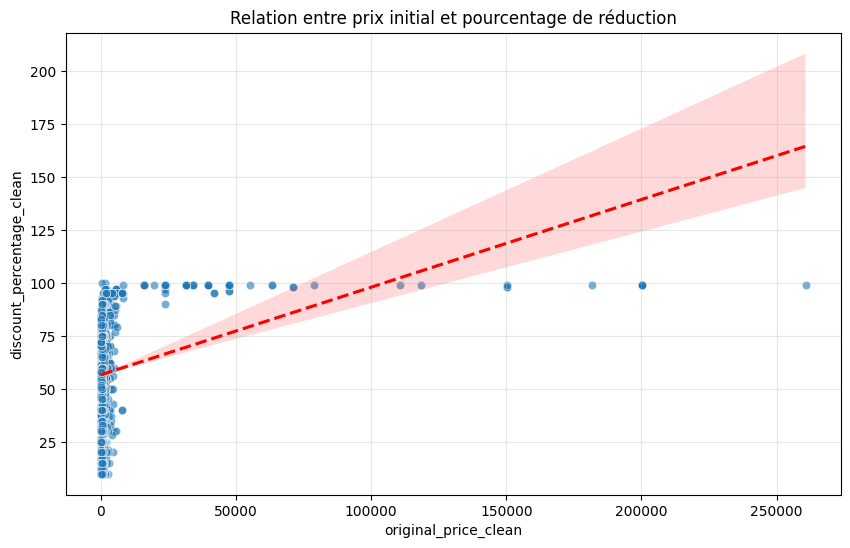


Modèle linéaire:
Coefficient: 0.0004
Constante: 56.5957
R² (coefficient de détermination): 0.0331

Réduction moyenne par tranche de prix:
                  mean  count
price_range                  
0-10               NaN      0
10-20              NaN      0
20-30              NaN      0
30-40              NaN      0
40-50        24.533333     15
50+          57.357349   4844


C:\Users\jojod\AppData\Local\Temp\ipykernel_20240\2788897863.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_games_analysis['price_range'] = pd.cut(video_games_analysis['original_price_clean'],
C:\Users\jojod\AppData\Local\Temp\ipykernel_20240\2788897863.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_range_analysis = video_games_analysis.groupby('price_range')['discount_percentage_clean'].agg(['mean', 'count'])


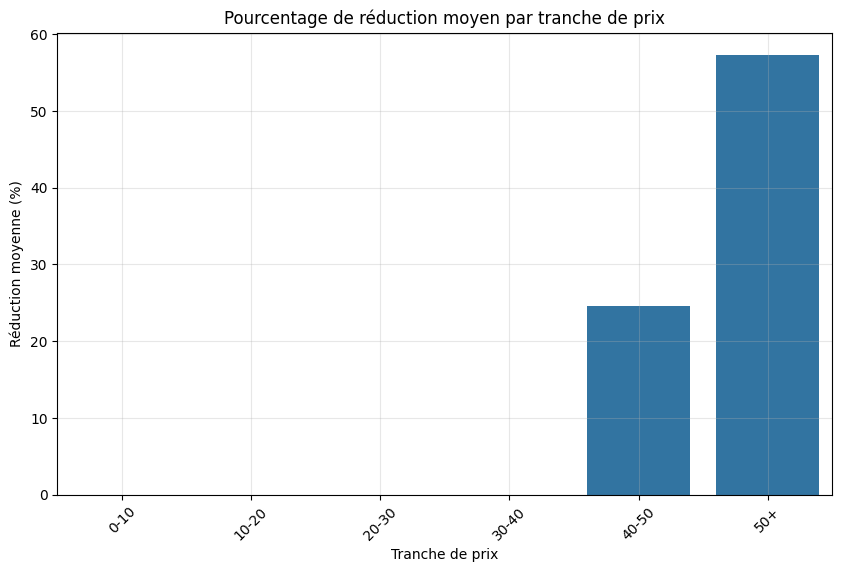


Réduction moyenne par quantile de prix:
                     mean  count
price_quantile                  
Q1              49.810273   1207
Q2              58.792722   1264
Q3              58.591027   1159
Q4              62.174486   1215


C:\Users\jojod\AppData\Local\Temp\ipykernel_20240\2788897863.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_games_analysis['price_quantile'] = pd.cut(video_games_analysis['original_price_clean'],
C:\Users\jojod\AppData\Local\Temp\ipykernel_20240\2788897863.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_analysis = video_games_analysis.groupby('price_quantile')['discount_percentage_clean'].agg(['mean', 'count'])


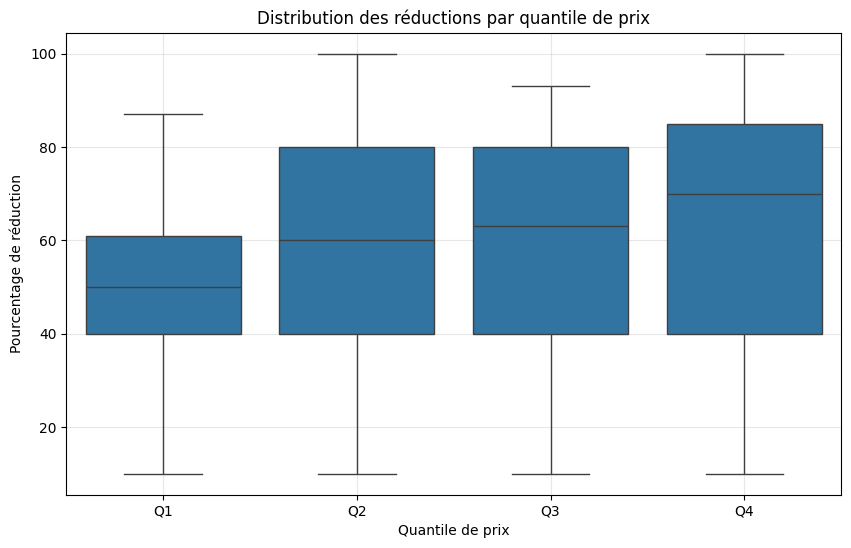

In [52]:
statistical_analysis_problem_1(Variable.original_price, Variable.discount_percentage, include_graph = True)

In [53]:
def statistical_analysis_quantitative_qualitative():
    pass

In [54]:
def statistical_analysis_qualitative_qualitative():
    pass